<a href="https://colab.research.google.com/github/sujitpal/nlp-deeplearning-ai-examples/blob/master/03_04_siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Siamese Network to detect Duplicate Questions

We use the [Quora Question Pair Dataset](https://www.kaggle.com/c/quora-question-pairs/data) from Kaggle to build a Siamese Network that predicts if a pair of questions are duplicate or not.

We only use the `train.csv` file, containing total of 404,301 labeled question pairs, for our exercise, carving out a validation set for evaluating the model during training, and a test set to evaluate the trained model.

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%ls "drive/My Drive/nlp-deeplearning-ai-data/quora-question-pairs.csv"

'drive/My Drive/nlp-deeplearning-ai-data/quora-question-pairs.csv'


In [3]:
DATA_DIR = "drive/My Drive/nlp-deeplearning-ai-data"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

from torch.utils.data import Dataset, DataLoader

%matplotlib inline

### Explore Data

In [5]:
qpairs_df = pd.read_csv(os.path.join(DATA_DIR, "quora-question-pairs.csv"))
qpairs_df = qpairs_df.dropna(subset=["question1", "question2"])
# qpairs_df = qpairs_df[0:5000]
qpairs_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
qpairs_df["is_duplicate"].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

### Split and Vectorize Data 

In [7]:
qpairs_tv, qpairs_test = train_test_split(qpairs_df, test_size=0.1, 
                                          stratify=qpairs_df["is_duplicate"], 
                                          random_state=0)
qpairs_train, qpairs_val = train_test_split(qpairs_tv, test_size=0.1, 
                                            stratify=qpairs_tv["is_duplicate"],
                                            random_state=0)

len(qpairs_train), len(qpairs_val), len(qpairs_test)

(327472, 36386, 40429)

In [8]:
vec = CountVectorizer(lowercase=True)
questions = []

vec.fit(np.concatenate([qpairs_train["question1"].values, 
                        qpairs_train["question2"].values], axis=0))
len(vec.vocabulary_)

78471

In [9]:
word2idx = {w:i+2 for i, w in enumerate(vec.vocabulary_)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1
idx2word = {v:k for k, v in word2idx.items()}

### Sequence Length Determination

In [10]:
lengths = []
lengths.extend([len(q.split()) for q in qpairs_df["question1"].values])
lengths.extend([len(q.split()) for q in qpairs_df["question2"].values])

np.percentile(lengths, [75, 80, 90, 95, 99])

array([13., 14., 18., 23., 31.])

In [11]:
maxlen = 35

### Dataset and DataLoader

In [12]:
class QuestionDataset(Dataset):

  def __init__(self, dataframe, word2index, maxlen):
    super(QuestionDataset, self).__init__()
    self.dataframe = dataframe
    self.word2index = word2index
    self.maxlen = maxlen

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    # extract data points for idx
    q1, q2, label = self.dataframe.iloc[idx][["question1", "question2", "is_duplicate"]]
    # convert strings to int sequence, truncate and/or pad
    w1 = [self._lookup(w) for w in q1.lower().split()]
    if len(w1) > self.maxlen:
      w1 = w1[0:self.maxlen]
    else:
      w1.extend([self.word2index["PAD"]] * (self.maxlen - len(w1)))
    w2 = [self._lookup(w) for w in q2.lower().split()]
    if len(w2) > self.maxlen:
      w2 = w2[0:self.maxlen]
    else:
      w2.extend([self.word2index["PAD"]] * (self.maxlen - len(w2)))
    # convert to tensors
    t1 = torch.tensor(w1, dtype=torch.long)
    t2 = torch.tensor(w2, dtype=torch.long)
    tl = torch.tensor(label, dtype=torch.long)
    return (t1, t2, tl)

  def _lookup(self, w):
    try:
      return self.word2index[w]
    except KeyError:
      return self.word2index["UNK"]

train_ds = QuestionDataset(qpairs_train, word2idx, maxlen)
val_ds = QuestionDataset(qpairs_val, word2idx, maxlen)
test_ds = QuestionDataset(qpairs_test, word2idx, maxlen)

len(train_ds), len(val_ds), len(test_ds)

(327472, 36386, 40429)

In [13]:
batch_size = 128

In [14]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

### Network

In [15]:
class SiameseNetwork(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers):
    super(SiameseNetwork, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
    self.dropout = nn.Dropout(0.2)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, 
                        batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x1, x2, states):
    x1, states = self._forward_single(x1, states)
    x2, states = self._forward_single(x2, states)
    return x1, x2, states

  def _forward_single(self, x, states):
    x = self.embedding(x)
    x = self.dropout(x)
    x, states = self.lstm(x, states)
    x = self.linear(x[:, -1, :])
    return x, states

In [16]:
embed_size = 300
hidden_size = 50
output_size = 1
num_layers = 3

net = SiameseNetwork(len(word2idx), embed_size, hidden_size, output_size, num_layers)
print(net)

SiameseNetwork(
  (embedding): Embedding(78473, 300, padding_idx=0)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 50, num_layers=3, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [17]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(dev)

### Self-test

In [18]:
with torch.no_grad():
  state = None
  for inputs1, inputs2, labels in train_dl:
    inputs1, inputs2, labels = inputs1.to(dev), inputs2.to(dev), labels.to(dev)
    outputs1, outputs2, _ = net(inputs1, inputs2, state)
    break
outputs1.shape, outputs2.shape

(torch.Size([128, 1]), torch.Size([128, 1]))

### Training Loop

In [19]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    From: https://gist.github.com/harveyslash/725fcc68df112980328951b3426c0e0b#file-contrastive-loss-py
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


def repackage_hidden(h):
  """
    Training loop crashes with weird errors about loss.backward() being run twice
    without retaining intermediate results.
    Pytorch 1.x way to handle this -- from:
    https://stackoverflow.com/questions/48274929/pytorch-runtimeerror-trying-to-backward-through-the-graph-a-second-time-but/48278089#48278089
    Wraps hidden states in new Tensors, to detach them from their history.
  """
  if isinstance(h, torch.Tensor):
      return h.detach()
  else:
      return tuple(repackage_hidden(v) for v in h)


In [20]:
loss_fn = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [21]:
def predict(model, dev, inputs1, inputs2, threshold=0.5):
  with torch.no_grad():
    inputs1, inputs2 = inputs1.to(dev), inputs2.to(dev)
    outputs1, outputs2, _ = model(inputs1, inputs2, None)
    euc_dists = F.pairwise_distance(outputs1, outputs2)
    results = [(1 if x > threshold else 0) for x in euc_dists]
  return results


def evaluate(model, dev, loader, loss_fn):
  state = None
  val_loss = 0
  y_true, y_pred = [], []
  with torch.no_grad():
    for inputs1, inputs2, labels in loader:

      if len(inputs1) != batch_size:
        continue

      inputs1, inputs2, labels = inputs1.to(dev), inputs2.to(dev), labels.to(dev)
      outputs1, outputs2, _ = model(inputs1, inputs2, state)

      val_loss += loss_fn(outputs1, outputs2, labels)
      preds = predict(net, dev, inputs1, inputs2)

      y_pred.extend(preds)
      y_true.extend(labels.detach().cpu().tolist())

  val_mse = mean_squared_error(y_pred, y_true)
  return val_loss, val_mse


In [22]:
num_epochs = 50

train_losses, train_mses, val_losses, val_mses = [], [], [], []
for i in range(1, num_epochs + 1):
  
  train_loss = 0
  y_true, y_pred = [], []
  state = None

  for inputs1, inputs2, labels in train_dl:

    if len(inputs1) != batch_size:
      continue

    inputs1, inputs2, labels = inputs1.to(dev), inputs2.to(dev), labels.to(dev)

    outputs1, outputs2, state = net(inputs1, inputs2, state)
    loss = loss_fn(outputs1, outputs2, labels)
    train_loss += loss.detach().cpu().item()

    preds = predict(net, dev, inputs1, inputs2)

    y_pred.extend(preds)
    y_true.extend(labels.detach().cpu().tolist())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    state = repackage_hidden(state)

  # evaluate after epoch
  train_mse = mean_squared_error(y_pred, y_true)
  val_loss, val_mse = evaluate(net, dev, val_dl, loss_fn)

  train_losses.append(train_loss)
  train_mses.append(train_mse)
  val_losses.append(val_loss)
  val_mses.append(val_mse)

  print("EPOCH {:d}, train loss: {:.3f}, train MSE: {:.3f}, val loss: {:.3f}, val MSE: {:.3f}"
    .format(i, train_loss, train_mse, val_loss, val_mse))


EPOCH 1, train loss: 2756.420, train MSE: 0.473, val loss: 428.516, val MSE: 0.503
EPOCH 2, train loss: 2397.987, train MSE: 0.429, val loss: 291.261, val MSE: 0.469
EPOCH 3, train loss: 2276.653, train MSE: 0.435, val loss: 224.604, val MSE: 0.436
EPOCH 4, train loss: 2171.017, train MSE: 0.400, val loss: 222.746, val MSE: 0.380
EPOCH 5, train loss: 1916.555, train MSE: 0.343, val loss: 205.033, val MSE: 0.335
EPOCH 6, train loss: 1753.531, train MSE: 0.311, val loss: 202.994, val MSE: 0.348
EPOCH 7, train loss: 1690.873, train MSE: 0.292, val loss: 195.330, val MSE: 0.314
EPOCH 8, train loss: 1594.057, train MSE: 0.310, val loss: 228.164, val MSE: 0.321
EPOCH 9, train loss: 1718.789, train MSE: 0.269, val loss: 245.969, val MSE: 0.287
EPOCH 10, train loss: 2132.663, train MSE: 0.280, val loss: 251.892, val MSE: 0.314
EPOCH 11, train loss: 2142.762, train MSE: 0.304, val loss: 234.068, val MSE: 0.346
EPOCH 12, train loss: 1682.323, train MSE: 0.297, val loss: 220.914, val MSE: 0.326
E

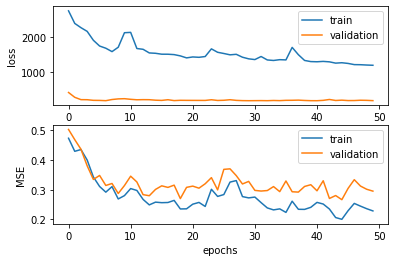

In [23]:
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(train_losses)), train_losses, label="train")
plt.plot(np.arange(len(val_losses)), val_losses, label="validation")
plt.legend(loc="best")
plt.ylabel("loss")

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(train_mses)), train_mses, label="train")
plt.plot(np.arange(len(val_mses)), val_mses, label="validation")
plt.legend(loc="best")
plt.ylabel("MSE")
plt.xlabel("epochs")

_ = plt.show()

### Evaluate Test Set

In [24]:
_, test_mses = evaluate(net, dev, test_dl, loss_fn)
print("Mean Square Error on test set: {:.3f}".format(test_mses))

Mean Square Error on test set: 0.297


In [25]:
preds, labels = None, None
for i, (inputs1, inputs2, labels) in enumerate(test_dl):
  preds = predict(net, dev, inputs1, inputs2)
  labels = labels.detach().numpy().tolist()
  batch = qpairs_test[0:batch_size]
  q1s = batch["question1"].values
  q2s = batch["question2"].values
  for q1, q2, pred, label in zip(q1s, q2s, preds, labels):
    print("{:d} | {:d} | {:30s} | {:30s}".format(label, pred, q1, q2))
  break

1 | 1 | Which is the best website for writing blogs? | What is the best website to write a blog?
1 | 1 | What are the best places to visit on a 3-day trip in and around Kerala? | What are the best places to visit in Kerala for college students?
0 | 0 | Where can I download free 220-901 practice test? | Where can I get free aptitude tests?
1 | 0 | How can I find out who has logged into my Instagram account? | Can I tell if someone logs into your Instagram account?
0 | 1 | How do I hack TP-Link router Wi-Fi to hack its password? | How can I hack router without knowing its password?
0 | 0 | Did Einstein say "Everybody is a genius but if you judge a fish by its ability to climb a tree it'll live its whole life believing that it's stupid"? | What is the most significant coincidence that has happened in your life?
0 | 0 | Is Russia a potential superpower? | What will Russia have to do to become a superpower?
0 | 0 | What is the meaning of ACR in context of Indian Navy? | How can I post like 

In [26]:
print(confusion_matrix(preds, labels))

[[55 12]
 [29 32]]


In [27]:
print("accuracy: {:.3f}".format(accuracy_score(preds, labels)))

accuracy: 0.680
